# DualCellQuant バッチ処理 (Step-by-Step)

大量の顕微鏡画像を連続処理するためのノートブック

## 処理フロー
1. 画像ファイルの読み込み
2. Cellpose-SAM セグメンテーション
3. Target/Reference マスク適用
4. 定量化 (Quantification)
5. Radial Profile 解析
6. Peak Difference 解析

## 1. セットアップ

In [1]:
import os
import sys
import glob
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm



# DualCellQuantモジュールをインポート
# testディレクトリから1つ上の階層のdualcellquantパッケージをインポート
parent_dir = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(parent_dir))

from dualcellquant.core import (
    run_segmentation,
    apply_mask,
    integrate_and_quantify,
)
from dualcellquant.radial import (
    radial_mask,
    radial_profile_all_cells,
    compute_radial_peak_difference,
)
from dualcellquant.visualization import (
    plot_radial_profile_with_peaks,
)

print("セットアップ完了")
print(f"DualCellQuantパス: {parent_dir}")


セットアップ完了
DualCellQuantパス: e:\Data\App\Python\dualCellQuant


In [2]:
# Jupyter Notebookでmatplotlibを表示するための設定
%matplotlib inline

## 2. パラメータ設定

In [3]:


# ========== セグメンテーションパラメータ ==========
SEG_PARAMS = {
    'source': 'reference',  # 'target' or 'reference'
    'channel': 'gray',   # 'gray', 'R', 'G', 'B'
    'diameter': 100,       # 0 = auto
    'flow_threshold': 0.4,
    'cellprob_threshold': 0.0,
    'use_gpu': True,
}

# ========== マスクパラメータ ==========
TARGET_MASK_PARAMS = {
    'channel': 'gray',
    'mode': 'none',  # 'none', 'global_percentile', 'global_otsu', 'per_cell_percentile', 'per_cell_otsu'
    'percentile': 75.0,
    'saturation_limit': 254,
    'min_object_size': 50,
}

REFERENCE_MASK_PARAMS = {
    'channel': 'gray',
    'mode': 'none',
    'percentile': 75.0,
    'saturation_limit': 254,
    'min_object_size': 50,
}

# ========== Radial Maskパラメータ ==========
RADIAL_MASK_PARAMS = {
    'inner_pct': 90.0,  # 内側の境界（%、0=中心、100=細胞境界）
    'outer_pct': 110.0,  # 外側の境界（%）
    'min_object_size': 50,  # 最小オブジェクトサイズ
}

# ========== 前処理パラメータ ==========
PREPROCESS_PARAMS = {
    'bg_enable': True,
    'bg_mode': 'dark_subtract',  # 'rolling', 'dark_subtract', 'manual'
    'bg_radius': 50,
    'bg_dark_pct': 5.0,
    'norm_enable': False,
    'norm_method': 'min-max',  # 'z-score', 'robust z-score', 'min-max', 'percentile [1,99]'
    'manual_tar_bg': None,
    'manual_ref_bg': None,
}

# ========== 定量化パラメータ ==========
QUANT_PARAMS = {
    'ratio_epsilon': 1e-6,
    'pixel_width_um': 0.207,
    'pixel_height_um': 0.207,
}

# ========== Radial Profileパラメータ ==========
RADIAL_PARAMS = {
    'start_pct': 0.0,
    'end_pct': 150.0,
    'window_size_pct': 5.0,
    'window_step_pct': 1.0,
}

# ========== Peak Differenceパラメータ ==========
PEAK_PARAMS = {
    'min_pct': 60.0,
    'max_pct': 120.0,
}

print("パラメータ設定完了")

パラメータ設定完了


## 3. 画像ファイルリストの作成

In [4]:
# ========== 入力ファイル設定 ==========
# 画像ディレクトリ（再帰的に検索）
INPUT_DIR = r"E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ"

# Target/Referenceの識別パターン（正規表現）
TARGET_PATTERN = r"(.+)_C001(Z\d+)\.tif"  # Target画像のパターン
REFERENCE_PATTERN = r"(.+)_C002(Z\d+)\.tif"  # Reference画像のパターン

# 出力ディレクトリ
OUTPUT_DIR = r"E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results"

print("入出力設定完了")
print(f"入力ディレクトリ: {INPUT_DIR}")
print(f"出力ディレクトリ: {OUTPUT_DIR}")

入出力設定完了
入力ディレクトリ: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ
出力ディレクトリ: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results


In [5]:
import re

# 再帰的に.tifファイルを検索してペアを作成
def find_image_pairs(input_dir, target_pattern, reference_pattern):
    """
    指定ディレクトリから再帰的にTIFファイルを検索し、
    Target/Referenceのペアを抽出
    """
    target_re = re.compile(target_pattern)
    reference_re = re.compile(reference_pattern)
    
    # すべてのtifファイルを再帰的に検索
    all_tifs = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith('.tif') or file.lower().endswith('.tiff'):
                full_path = os.path.join(root, file)
                all_tifs.append(full_path)
    
    print(f"検索完了: {len(all_tifs)} 個のTIFファイルを発見")
    
    # Targetファイルを抽出
    target_files = {}
    for path in all_tifs:
        filename = os.path.basename(path)
        match = target_re.match(filename)
        if match:
            # グループ1: ベース名、グループ2: Z番号
            base = match.group(1)
            z_num = match.group(2) if len(match.groups()) > 1 else ""
            key = (base, z_num)
            target_files[key] = path
    
    # Referenceファイルを抽出
    reference_files = {}
    for path in all_tifs:
        filename = os.path.basename(path)
        match = reference_re.match(filename)
        if match:
            base = match.group(1)
            z_num = match.group(2) if len(match.groups()) > 1 else ""
            key = (base, z_num)
            reference_files[key] = path
    
    # ペアを作成
    pairs = []
    for key in sorted(target_files.keys()):
        if key in reference_files:
            pairs.append((target_files[key], reference_files[key]))
        else:
            print(f"  警告: Target {key} に対応するReferenceが見つかりません")
    
    # Referenceのみのファイルをチェック
    for key in reference_files.keys():
        if key not in target_files:
            print(f"  警告: Reference {key} に対応するTargetが見つかりません")
    
    return pairs

# 画像ペアを自動検出
IMAGE_PAIRS = find_image_pairs(INPUT_DIR, TARGET_PATTERN, REFERENCE_PATTERN)

print(f"\n処理対象: {len(IMAGE_PAIRS)} ペアの画像")
for i, (tgt, ref) in enumerate(IMAGE_PAIRS[:5], 1):  # 最初の5ペアを表示
    print(f"  {i}. Target: {Path(tgt).name}")
    print(f"     Reference: {Path(ref).name}")
if len(IMAGE_PAIRS) > 5:
    print(f"  ... 他 {len(IMAGE_PAIRS) - 5} ペア")

検索完了: 96 個のTIFファイルを発見

処理対象: 32 ペアの画像
  1. Target: 4h.0_C001Z001.tif
     Reference: 4h.0_C002Z001.tif
  2. Target: 4h.0_C001Z002.tif
     Reference: 4h.0_C002Z002.tif
  3. Target: 4h.0_C001Z003.tif
     Reference: 4h.0_C002Z003.tif
  4. Target: 4h.0_C001Z004.tif
     Reference: 4h.0_C002Z004.tif
  5. Target: 4h.0.5_C001Z001.tif
     Reference: 4h.0.5_C002Z001.tif
  ... 他 27 ペア


## 4. 出力ディレクトリの作成

In [6]:
# 出力ディレクトリを作成
# 構造:
# Results/
#   ├── sample1/
#   │   ├── masks/
#   │   ├── overlays/
#   │   ├── radial_profile_plots/
#   │   ├── quantification.csv
#   │   ├── radial_profiles.csv
#   │   └── peak_differences.csv
#   ├── sample2/
#   │   └── ...
#   ├── all_samples_quantification.csv
#   └── all_samples_peak_differences.csv

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"出力ディレクトリ: {OUTPUT_DIR}")



出力ディレクトリ: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results


## 5. 単一画像ペアの処理（テスト用）

まず1つの画像ペアで処理をテストします

In [7]:
# テスト用に最初の1ペアを選択
if IMAGE_PAIRS:
    test_target, test_reference = IMAGE_PAIRS[0]
    print(f"テスト画像:")
    print(f"  Target: {test_target}")
    print(f"  Reference: {test_reference}")
else:
    print("画像ペアが見つかりません。IMAGE_PAIRS を設定してください。")

# ファイル名のベースを生成
def generate_base_name(target_path, target_pattern):
    """
    Targetファイルパスとパターンからbase_nameを生成
    """
    filename = os.path.basename(target_path)
    match = re.match(target_pattern, filename)
    if match:
        # グループ1: ベース名、グループ2: Z番号
        base = match.group(1)
        z_num = match.group(2) if len(match.groups()) > 1 else ""
        # Z番号を含めたbase_name
        return f"{base}_{z_num}" if z_num else base
    else:
        # パターンにマッチしない場合は拡張子を除いたファイル名
        return Path(target_path).stem

base_name = generate_base_name(test_target, TARGET_PATTERN)
print(f"Base name: {base_name}")

# サンプル用の出力ディレクトリを作成
sample_output_dir = os.path.join(OUTPUT_DIR, base_name)

テスト画像:
  Target: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\4h.0.tif.frames\4h.0_C001Z001.tif
  Reference: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\4h.0.tif.frames\4h.0_C002Z001.tif
Base name: 4h.0_Z001


### Step 1: 画像の読み込み

Target画像サイズ: (1024, 1024)
Reference画像サイズ: (1024, 1024)


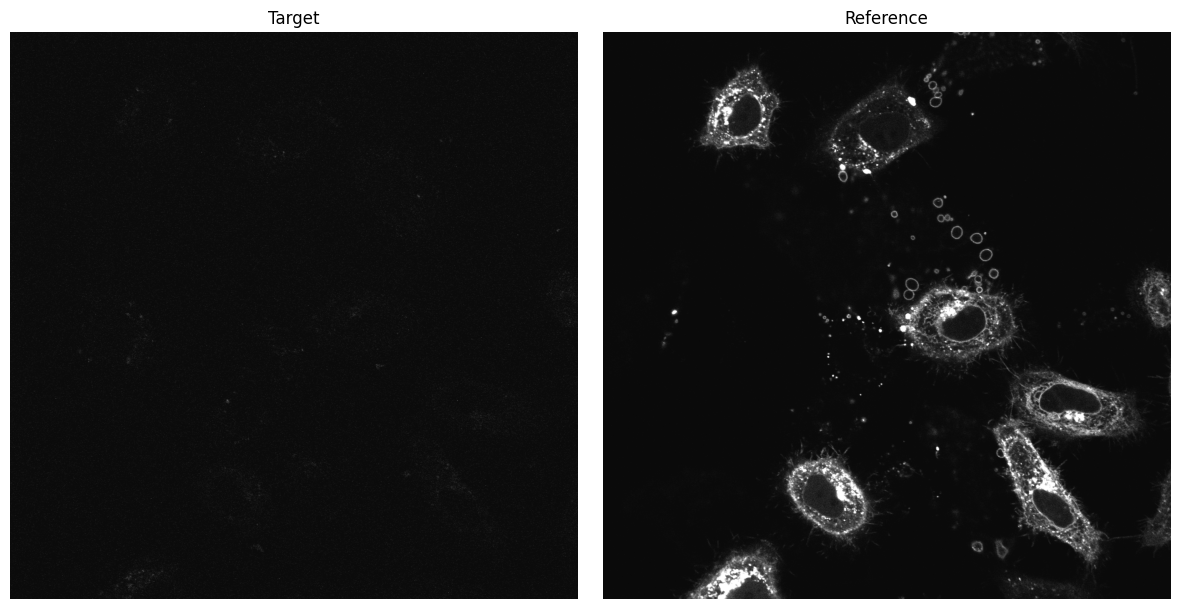

In [8]:
# 画像を読み込み
target_img = Image.open(test_target)
reference_img = Image.open(test_reference)

# RGBに変換（グレースケールの場合）
if target_img.mode != 'RGB':
    target_img = target_img.convert('RGB')
if reference_img.mode != 'RGB':
    reference_img = reference_img.convert('RGB')

print(f"Target画像サイズ: {target_img.size}")
print(f"Reference画像サイズ: {reference_img.size}")

# 画像を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(target_img)
axes[0].set_title('Target')
axes[0].axis('off')
axes[1].imshow(reference_img)
axes[1].set_title('Reference')
axes[1].axis('off')
plt.tight_layout()
plt.show()

### Step 2: Cellpose-SAM セグメンテーション

channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
Resizing is deprecated in v4.0.1+


検出された細胞数: 9


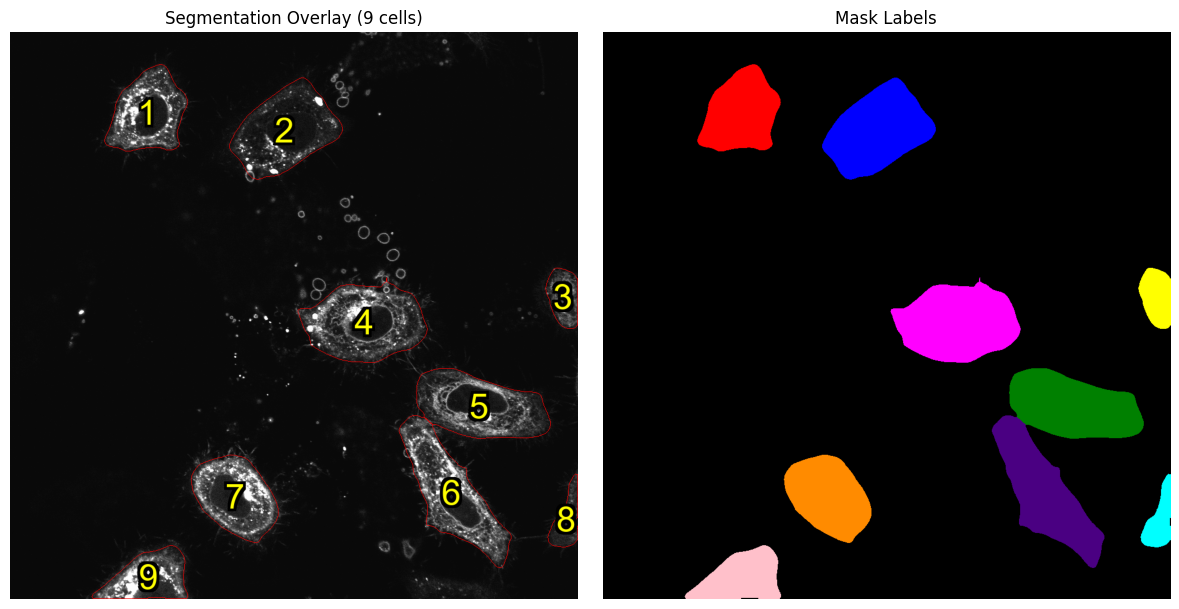

In [9]:
# セグメンテーション実行
seg_overlay, seg_tiff, mask_img, masks = run_segmentation(
    target_img,
    reference_img,
    seg_source=SEG_PARAMS['source'],
    seg_channel=SEG_PARAMS['channel'],
    diameter=SEG_PARAMS['diameter'],
    flow_threshold=SEG_PARAMS['flow_threshold'],
    cellprob_threshold=SEG_PARAMS['cellprob_threshold'],
    use_gpu=SEG_PARAMS['use_gpu'],
)

n_cells = len(np.unique(masks)) - 1  # 背景を除く
print(f"検出された細胞数: {n_cells}")

# セグメンテーション結果を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(seg_overlay)
axes[0].set_title(f'Segmentation Overlay ({n_cells} cells)')
axes[0].axis('off')
axes[1].imshow(mask_img)
axes[1].set_title('Mask Labels')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 3: Target/Reference マスク適用

マスク適用完了


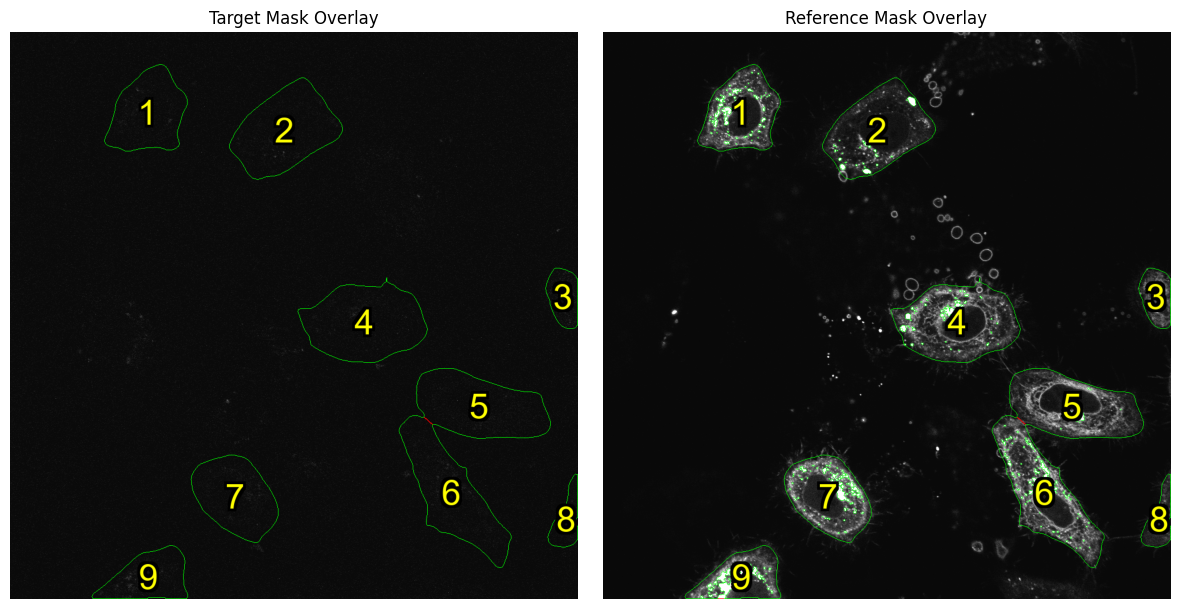

In [10]:
# Targetマスク適用
tgt_overlay, tgt_tiff, tgt_mask = apply_mask(
    target_img,
    masks,
    measure_channel=TARGET_MASK_PARAMS['channel'],
    sat_limit=TARGET_MASK_PARAMS['saturation_limit'],
    mask_mode=TARGET_MASK_PARAMS['mode'],
    pct=TARGET_MASK_PARAMS['percentile'],
    min_obj_size=TARGET_MASK_PARAMS['min_object_size'],
    mask_name="target_mask",
)

# Referenceマスク適用
ref_overlay, ref_tiff, ref_mask = apply_mask(
    reference_img,
    masks,
    measure_channel=REFERENCE_MASK_PARAMS['channel'],
    sat_limit=REFERENCE_MASK_PARAMS['saturation_limit'],
    mask_mode=REFERENCE_MASK_PARAMS['mode'],
    pct=REFERENCE_MASK_PARAMS['percentile'],
    min_obj_size=REFERENCE_MASK_PARAMS['min_object_size'],
    mask_name="reference_mask",
)

print("マスク適用完了")

# マスク結果を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(tgt_overlay)
axes[0].set_title('Target Mask Overlay')
axes[0].axis('off')
axes[1].imshow(ref_overlay)
axes[1].set_title('Reference Mask Overlay')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 4: 定量化 (Integrate & Quantify)

In [11]:
# 定量化実行
result = integrate_and_quantify(
    target_img,
    reference_img,
    masks,
    tgt_mask,
    ref_mask,
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    pixel_width_um=QUANT_PARAMS['pixel_width_um'],
    pixel_height_um=QUANT_PARAMS['pixel_height_um'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
)

(
    tgt_and_overlay, ref_and_overlay, and_mask_tiff,
    quant_df, quant_csv,
    tgt_on_and, ref_on_and, ratio_on_and
) = result

print(f"定量化完了: {len(quant_df)} 細胞")
print("\n定量化結果（最初の5行）:")
display(quant_df.head())


定量化完了: 9 細胞

定量化結果（最初の5行）:


,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,mean_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_all_pixels,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,1,16186,693.553914,15528,665.359272,43715.648438,2.815279,4.319063,917219.250,59.068729,...,1912.739585,0.123180,5.008153,0.047661,47888.593750,2.958643,4.587116,1.078414e+06,66.626350,58.854950
1,2,22271,954.290079,21864,936.850536,60146.046875,2.750917,4.400974,614005.750,28.082956,...,3810.227259,0.174269,0.396132,0.097957,62380.664062,2.800982,4.465672,7.137114e+05,32.046673,41.494442
2,3,5034,215.701866,5020,215.101980,25803.765625,5.140193,6.407266,244265.625,48.658489,...,722.357272,0.143896,0.256765,0.105638,25950.781250,5.155102,6.427228,2.476953e+05,49.204472,32.208992
3,4,24668,1056.999132,24051,1030.561299,64600.109375,2.685964,4.265188,1332886.375,55.419167,...,2083.765044,0.086639,0.217382,0.048466,68602.976562,2.781051,4.407912,1.484037e+06,60.160419,53.234390
4,5,22288,955.018512,22039,944.349111,65478.875000,2.971046,4.514380,1146213.750,52.008427,...,2226.512279,0.101026,0.259735,0.057126,67519.187500,3.029397,4.590359,1.207213e+06,54.164257,48.146614


### Step 5: Radial Mask定量化

細胞の外周部分（radial ring）のみでの定量化を行います。

Radial Mask生成完了
  内側境界: 90.0%
  外側境界: 110.0%

Radial Mask定量化完了: 9 細胞

Radial Mask定量化結果（最初の5行）:

Radial Mask定量化完了: 9 細胞

Radial Mask定量化結果（最初の5行）:


,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,mean_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_all_pixels,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,1,16186,693.553914,5788,248.010012,11737.763672,2.027948,3.353665,98523.445312,17.022018,...,5.615354e+04,9.701717,185.434972,0.119137,47888.593750,2.958643,4.587116,1.078414e+06,66.626350,58.854950
1,2,22271,954.290079,6919,296.472231,14228.843750,2.056489,3.442862,108416.265625,15.669354,...,1.195009e+05,17.271413,300.314583,0.131243,62380.664062,2.800982,4.465672,7.137114e+05,32.046673,41.494442
2,3,5034,215.701866,1618,69.329682,4823.853027,2.981368,4.723577,24684.130859,15.255952,...,6.103992e+03,3.772554,86.107968,0.195423,25950.781250,5.155102,6.427228,2.476953e+05,49.204472,32.208992
3,4,24668,1056.999132,8015,343.434735,16060.912109,2.003857,3.706345,181824.687500,22.685551,...,8.666326e+04,10.812634,219.821408,0.088332,68602.976562,2.781051,4.407912,1.484037e+06,60.160419,53.234390
4,5,22288,955.018512,6166,264.206934,12707.437500,2.060888,3.545430,112527.640625,18.249699,...,1.109822e+06,179.990597,12761.720860,0.112927,67519.187500,3.029397,4.590359,1.207213e+06,54.164257,48.146614


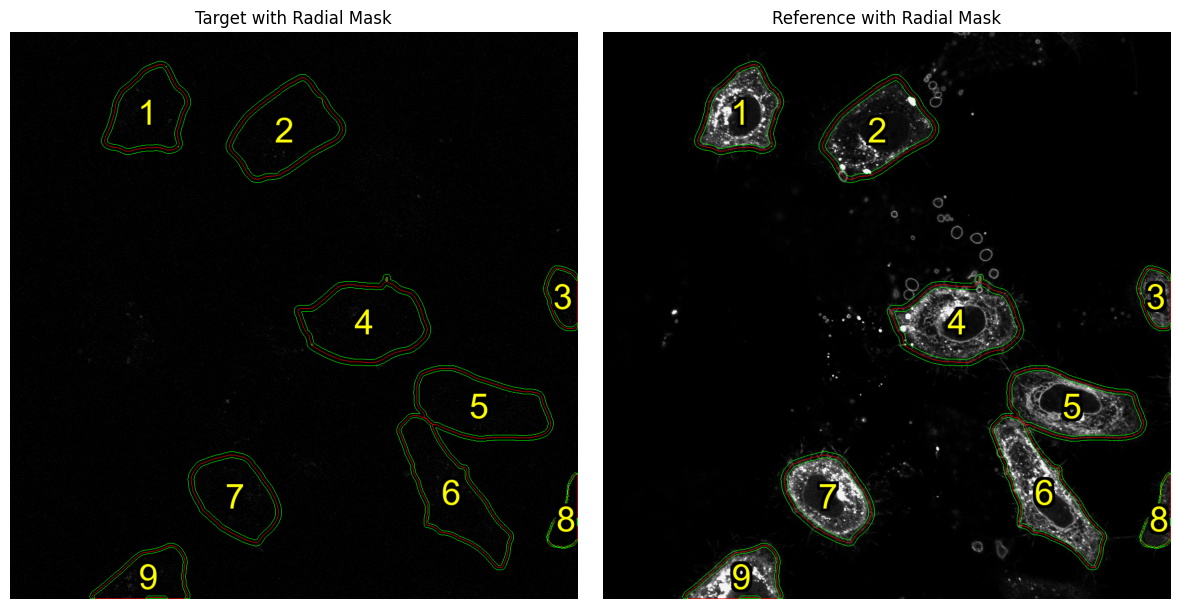

In [12]:

# 1. Radial Maskを生成
radial_overlay, radial_bool_mask, radial_label_mask, radial_bool_tiff, radial_label_tiff = radial_mask(
    masks=masks,
    inner_pct=RADIAL_MASK_PARAMS['inner_pct'],
    outer_pct=RADIAL_MASK_PARAMS['outer_pct'],
    min_obj_size=RADIAL_MASK_PARAMS['min_object_size'],
)

print(f"Radial Mask生成完了")
print(f"  内側境界: {RADIAL_MASK_PARAMS['inner_pct']}%")
print(f"  外側境界: {RADIAL_MASK_PARAMS['outer_pct']}%")

# # Radial Maskを表示
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(radial_overlay)
# axes[0].set_title('Radial Mask Overlay')
# axes[0].axis('off')
# axes[1].imshow(radial_bool_mask, cmap='gray')
# axes[1].set_title('Radial Mask (Boolean)')
# axes[1].axis('off')
# plt.tight_layout()
# plt.show()

# 2. Radial Maskを使った定量化
# Target/Reference maskの代わりにradial maskを使い、roi_mask/roi_labelsも指定
radial_quant_result = integrate_and_quantify(
    target_img,
    reference_img,
    masks,
    tgt_mask,  # Target mask（通常のマスク）
    ref_mask,  # Reference mask（通常のマスク）
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    pixel_width_um=QUANT_PARAMS['pixel_width_um'],
    pixel_height_um=QUANT_PARAMS['pixel_height_um'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
    roi_mask=radial_bool_mask,  # Radial MaskをROIとして指定
    roi_labels=radial_label_mask,  # Radial LabelをROIラベルとして指定
)

(
    radial_tgt_and_overlay, radial_ref_and_overlay, radial_and_mask_tiff,
    radial_quant_df, radial_quant_csv,
    radial_tgt_on_and, radial_ref_on_and, radial_ratio_on_and
) = radial_quant_result

print(f"\nRadial Mask定量化完了: {len(radial_quant_df)} 細胞")
print("\nRadial Mask定量化結果（最初の5行）:")
display(radial_quant_df.head())

# Radial Maskを適用したオーバーレイ画像を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(radial_tgt_and_overlay)
axes[0].set_title('Target with Radial Mask')
axes[0].axis('off')
axes[1].imshow(radial_ref_and_overlay)
axes[1].set_title('Reference with Radial Mask')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 6: Radial Profile 解析


In [13]:
# Radial Profile解析実行
radial_df, radial_csv = radial_profile_all_cells(
    target_img,
    reference_img,
    masks,
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    start_pct=RADIAL_PARAMS['start_pct'],
    end_pct=RADIAL_PARAMS['end_pct'],
    window_size_pct=RADIAL_PARAMS['window_size_pct'],
    window_step_pct=RADIAL_PARAMS['window_step_pct'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
)

print(f"Radial Profile解析完了: {len(radial_df)} データポイント")
print("\nRadial Profile結果（最初の5行）:")
display(radial_df.head())

Radial Profile解析完了: 1314 データポイント

Radial Profile結果（最初の5行）:


,label,band_start_pct,band_end_pct,center_pct,count_px,mean_target,mean_reference,std_target,std_reference,sem_target,sem_reference,mean_ratio_T_over_R,std_ratio_T_over_R,sem_ratio_T_over_R,count_ratio_px
0,1,0.0,5.0,2.5,76,2.751788,15.868440,4.082483,4.794913,0.468293,0.550014,0.164306,0.241301,0.027679,76
1,1,1.0,6.0,3.5,96,2.564306,16.052084,3.956776,4.697503,0.403837,0.479437,0.164899,0.261049,0.026643,96
2,1,2.0,7.0,4.5,116,2.312176,16.491336,3.681346,4.764424,0.341804,0.442366,0.148155,0.240956,0.022372,116
3,1,3.0,8.0,5.5,138,2.480076,16.586904,3.822746,5.300246,0.325414,0.451187,0.166649,0.280247,0.023856,138
4,1,4.0,9.0,6.5,154,2.495320,16.798627,3.996735,5.819577,0.322066,0.468955,0.169538,0.302192,0.024351,154


### Step 7: Peak Difference 解析

In [14]:
# Peak Difference解析実行
peak_df = compute_radial_peak_difference(
    radial_df,
    quant_df=quant_df,
    min_pct=PEAK_PARAMS['min_pct'],
    max_pct=PEAK_PARAMS['max_pct'],
)

print(f"Peak Difference解析完了: {len(peak_df)} 細胞")
print("\nPeak Difference結果:")
display(peak_df)

# 統計情報
if not peak_df.empty and 'difference_pct' in peak_df.columns:
    print(f"\nPeak Difference統計:")
    print(f"  平均: {peak_df['difference_pct'].mean():.2f} %")
    print(f"  中央値: {peak_df['difference_pct'].median():.2f} %")
    print(f"  標準偏差: {peak_df['difference_pct'].std():.2f} %")

Peak Difference解析完了: 9 細胞

Peak Difference結果:


,label,max_target_center_pct,max_reference_center_pct,difference_pct,max_target_px,max_reference_px,difference_px,max_target_um,max_reference_um,difference_um
0,1,69.5,65.5,4.0,49.886110,47.014967,2.871143,10.326425,9.732098,0.594327
1,2,84.5,85.5,-1.0,71.146187,71.988154,-0.841967,14.727261,14.901548,-0.174287
2,3,60.5,66.5,-6.0,24.217931,26.619710,-2.401778,5.013112,5.510280,-0.497168
3,4,70.5,78.5,-8.0,62.471387,69.560339,-7.088952,12.931577,14.398990,-1.467413
4,5,70.5,77.5,-7.0,59.381304,65.277320,-5.896016,12.291930,13.512405,-1.220475
5,6,61.5,78.5,-17.0,51.958514,66.321030,-14.362516,10.755412,13.728453,-2.973041
6,7,61.5,82.5,-21.0,45.128305,60.537970,-15.409665,9.341559,12.531360,-3.189801
7,8,60.5,71.5,-11.0,21.587902,25.512975,-3.925073,4.468696,5.281186,-0.812490
8,9,60.5,65.5,-5.0,35.718030,38.669933,-2.951903,7.393632,8.004676,-0.611044



Peak Difference統計:
  平均: -8.00 %
  中央値: -7.00 %
  標準偏差: 7.63 %


### Step 7-1: Radial Profile グラフの生成（全ラベル）


9 個の細胞についてRadial Profileグラフを生成中...


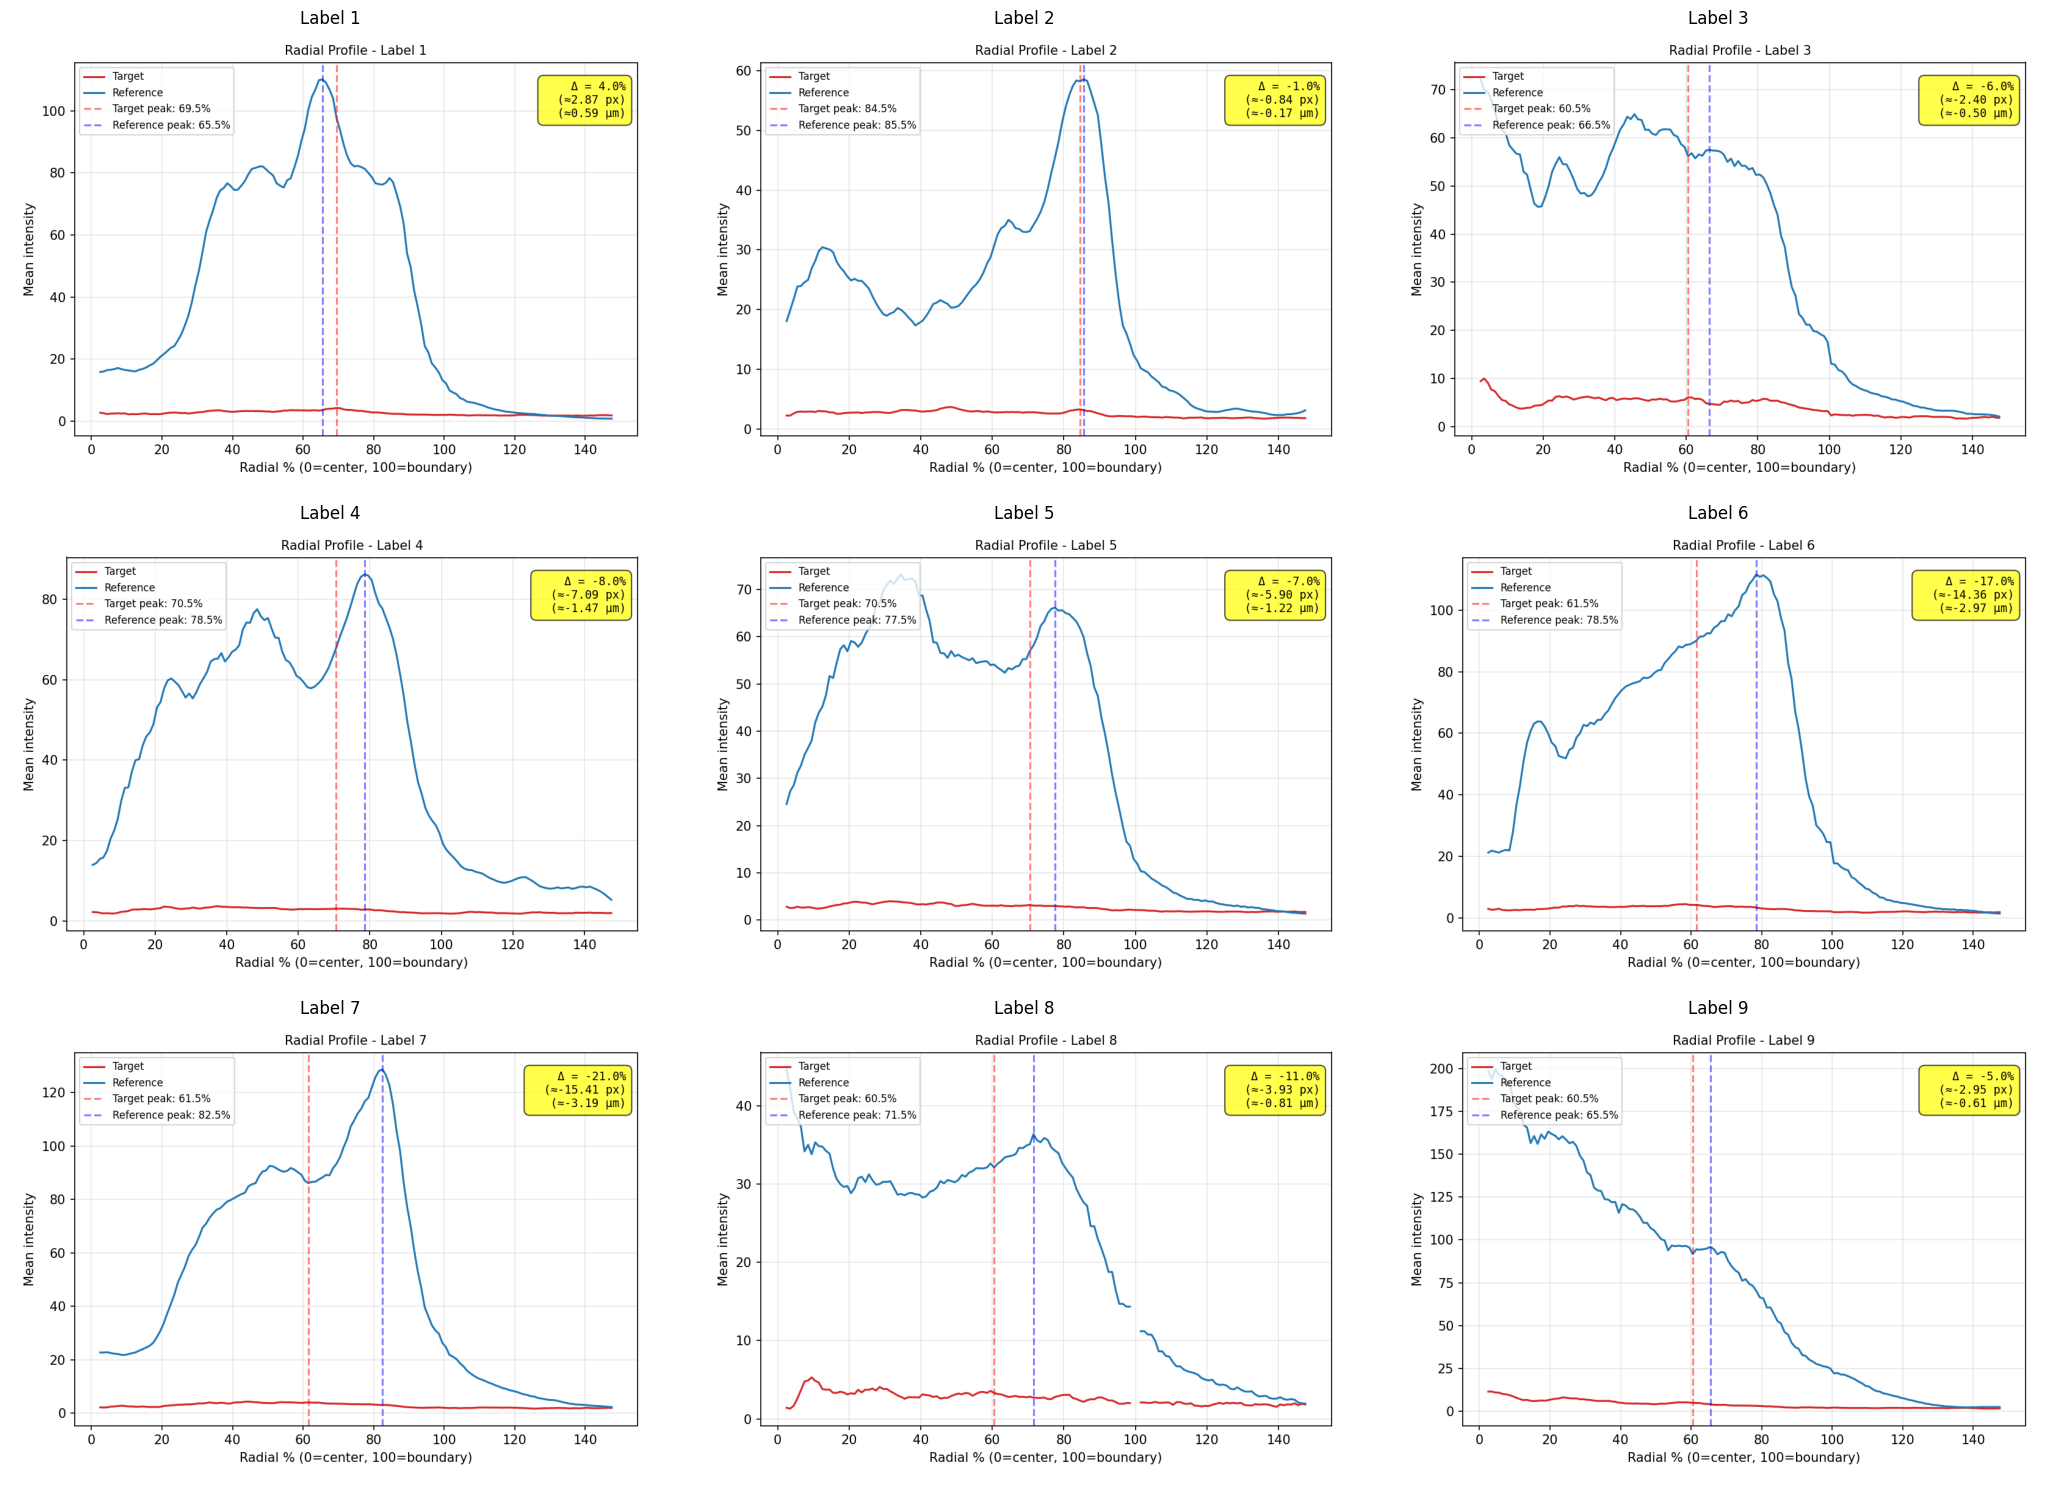

In [15]:
# すべてのラベルについてRadial Profileグラフを生成（T/Rは表示しない）
if not radial_df.empty and not peak_df.empty:
    # ユニークなラベルを取得
    unique_labels = sorted(radial_df['label'].unique())
    
    print(f"\n{len(unique_labels)} 個の細胞についてRadial Profileグラフを生成中...")
    
    
    # グラフを3列ずつすべて表示
    
    if unique_labels:
        n_column = 3
        n_row = (len(unique_labels) + n_column - 1) // n_column
        
        fig, axes = plt.subplots(n_row, n_column, figsize=(7 * n_column, 5 * n_row))
        axes = axes.flatten()  # 2D配列を1Dに変換

        for i, label in enumerate(unique_labels):
            plot_img = plot_radial_profile_with_peaks(
                df=radial_df,
                peak_df=peak_df,
                label_filter=label,
                window_bins=1,
                show_errorbars=False,
                show_ratio=False,
            )
            axes[i].imshow(plot_img)
            axes[i].axis('off')
            axes[i].set_title(f'Label {label}', fontsize=12)
        
        plt.tight_layout()
        plt.show()
else:
    print("Radial ProfileまたはPeak Differenceデータがありません")

### 結果の保存（テスト用）

In [16]:

os.makedirs(sample_output_dir, exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "masks"), exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "overlays"), exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "radial_profile_plots"), exist_ok=True)

# CSVファイルを保存
quant_output = os.path.join(sample_output_dir, "quantification.csv")
quant_df.to_csv(quant_output, index=False)
print(f"定量化結果を保存: {quant_output}")

radial_output = os.path.join(sample_output_dir, "radial_profiles.csv")
radial_df.to_csv(radial_output, index=False)
print(f"Radial Profile結果を保存: {radial_output}")

peak_output = os.path.join(sample_output_dir, "peak_differences.csv")
peak_df.to_csv(peak_output, index=False)
print(f"Peak Difference結果を保存: {peak_output}")

# Radial Mask定量化結果を保存（有効な場合）
if radial_quant_df is not None:
    radial_quant_output = os.path.join(sample_output_dir, "radial_mask_quantification.csv")
    radial_quant_df.to_csv(radial_quant_output, index=False)
    print(f"Radial Mask定量化結果を保存: {radial_quant_output}")

# オーバーレイ画像を保存
seg_overlay.save(os.path.join(sample_output_dir, "overlays", "segmentation_overlay.png"))
tgt_overlay.save(os.path.join(sample_output_dir, "overlays", "target_mask_overlay.png"))
ref_overlay.save(os.path.join(sample_output_dir, "overlays", "reference_mask_overlay.png"))

# Radial Maskオーバーレイを保存（有効な場合）
if radial_overlay is not None:
    radial_overlay.save(os.path.join(sample_output_dir, "overlays", "radial_mask_overlay.png"))

# マスクTIFFを保存
Image.fromarray(masks.astype(np.uint16)).save(os.path.join(sample_output_dir, "masks", "cell_masks.tif"))

# Radial Maskを保存（有効な場合）
if radial_bool_mask is not None:
    Image.fromarray((radial_bool_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", "radial_mask.tif"))

# Radial Profileグラフを保存
if not radial_df.empty and not peak_df.empty:
    for label in unique_labels:
        plot_img = plot_radial_profile_with_peaks(
            df=radial_df,
            peak_df=peak_df,
            label_filter=label,
            window_bins=1,
            show_errorbars=False,
            show_ratio=False,
        )
        plot_path = os.path.join(sample_output_dir, "radial_profile_plots", f"radial_profile_label_{label}.png")
        plot_img.save(plot_path)
        print(f"Radial Profileグラフを保存: {plot_path}")

print(f"\nすべての結果を保存: {sample_output_dir}")

定量化結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z001\quantification.csv
Radial Profile結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z001\radial_profiles.csv
Peak Difference結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z001\peak_differences.csv
Radial Mask定量化結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z001\radial_mask_quantification.csv
Radial Profileグラフを保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z001\radial_profile_plots\radial_profile_label_1.png
Radial Profileグラフを保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z001\radial_profile_plots\radial_profile_label_2.png
Radial Profileグラフを保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z001\radial_profile_plots\radial_profile_label_1.png
Radial Profileグラフを保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z001\radial_profile_plots\radial_profile_label_2

## 6. バッチ処理（全画像ペア）

上記のテストが成功したら、全画像ペアをバッチ処理します

In [17]:
# バッチ処理関数
def process_image_pair(target_path, reference_path, output_dir, target_pattern):
    """
    1ペアの画像を処理する関数
    """
    try:
        # base_nameを生成
        base_name = generate_base_name(target_path, target_pattern)
        
        # サンプル用の出力ディレクトリを作成
        sample_output_dir = os.path.join(output_dir, base_name)
        os.makedirs(sample_output_dir, exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "masks"), exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "overlays"), exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "radial_profile_plots"), exist_ok=True)
        
        # 変数の初期化
        rad_overlay = None
        rad_bool_mask = None
        rad_label_mask = None
        radial_tar_overlay = None
        radial_ref_overlay = None
        radial_quant_df = None
        
        # 1. 画像読み込み
        target_img = Image.open(target_path)
        reference_img = Image.open(reference_path)
        if target_img.mode != 'RGB':
            target_img = target_img.convert('RGB')
        if reference_img.mode != 'RGB':
            reference_img = reference_img.convert('RGB')
        
        # 2. セグメンテーション
        seg_overlay, seg_tiff, mask_img, masks = run_segmentation(
            target_img,
            reference_img,
            seg_source=SEG_PARAMS['source'],
            seg_channel=SEG_PARAMS['channel'],
            diameter=SEG_PARAMS['diameter'],
            flow_threshold=SEG_PARAMS['flow_threshold'],
            cellprob_threshold=SEG_PARAMS['cellprob_threshold'],
            use_gpu=SEG_PARAMS['use_gpu'],
        )
        n_cells = len(np.unique(masks)) - 1
        
        # 3. マスク適用
        tgt_overlay, tgt_tiff, tgt_mask = apply_mask(
            target_img, masks,
            measure_channel=TARGET_MASK_PARAMS['channel'],
            sat_limit=TARGET_MASK_PARAMS['saturation_limit'],
            mask_mode=TARGET_MASK_PARAMS['mode'],
            pct=TARGET_MASK_PARAMS['percentile'],
            min_obj_size=TARGET_MASK_PARAMS['min_object_size'],
            mask_name="target_mask",
        )
        ref_overlay, ref_tiff, ref_mask = apply_mask(
            reference_img, masks,
            measure_channel=REFERENCE_MASK_PARAMS['channel'],
            sat_limit=REFERENCE_MASK_PARAMS['saturation_limit'],
            mask_mode=REFERENCE_MASK_PARAMS['mode'],
            pct=REFERENCE_MASK_PARAMS['percentile'],
            min_obj_size=REFERENCE_MASK_PARAMS['min_object_size'],
            mask_name="reference_mask",
        )
        
        # 4. 定量化
        result = integrate_and_quantify(
            target_img, reference_img, masks, tgt_mask, ref_mask,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            pixel_width_um=QUANT_PARAMS['pixel_width_um'],
            pixel_height_um=QUANT_PARAMS['pixel_height_um'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
        )
        quant_df = result[3]
        
        
        # 5. Radial Mask定量化
       
        rad_overlay, rad_bool_mask, rad_label_mask, rad_bool_tiff, rad_label_tiff = radial_mask(
            masks=masks,
            inner_pct=RADIAL_MASK_PARAMS['inner_pct'],
            outer_pct=RADIAL_MASK_PARAMS['outer_pct'],
            min_obj_size=RADIAL_MASK_PARAMS['min_object_size'],
        )
        
        radial_quant_result = integrate_and_quantify(
            target_img, reference_img, masks, tgt_mask, ref_mask,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            pixel_width_um=QUANT_PARAMS['pixel_width_um'],
            pixel_height_um=QUANT_PARAMS['pixel_height_um'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
            roi_mask=rad_bool_mask,  # Radial Maskをオーバーレイ
            roi_labels=rad_label_mask,  # Radial Labelをオーバーレイ
        )
        # Radial Maskオーバーレイ画像を取得
        radial_tar_overlay = radial_quant_result[0]
        radial_ref_overlay = radial_quant_result[1]
        radial_quant_df = radial_quant_result[3]
        
        # 6. Radial Profile
        radial_df, radial_csv = radial_profile_all_cells(
            target_img, reference_img, masks,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            start_pct=RADIAL_PARAMS['start_pct'],
            end_pct=RADIAL_PARAMS['end_pct'],
            window_size_pct=RADIAL_PARAMS['window_size_pct'],
            window_step_pct=RADIAL_PARAMS['window_step_pct'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
        )
        
        # 7. Peak Difference
        peak_df = compute_radial_peak_difference(
            radial_df, quant_df=quant_df,
            min_pct=PEAK_PARAMS['min_pct'],
            max_pct=PEAK_PARAMS['max_pct'],
        )
        


        
        # 結果保存（CSVファイル）- base_nameをファイル名の頭に付ける
        quant_df.to_csv(os.path.join(sample_output_dir, f"{base_name}_quantification.csv"), index=False)
        radial_df.to_csv(os.path.join(sample_output_dir, f"{base_name}_radial_profiles.csv"), index=False)
        peak_df.to_csv(os.path.join(sample_output_dir, f"{base_name}_peak_differences.csv"), index=False)
        
        if radial_quant_df is not None:
            radial_quant_df.to_csv(os.path.join(sample_output_dir, f"{base_name}_radial_mask_quantification.csv"), index=False)
        
        # オーバーレイ画像を保存 - base_nameをファイル名の頭に付ける
        seg_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_segmentation_overlay.png"))
        tgt_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_target_mask_overlay.png"))
        ref_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_reference_mask_overlay.png"))
        
        if rad_overlay is not None:
            rad_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_radial_mask_overlay.png"))
        
        # Radial Mask定量化のオーバーレイ画像を保存 - base_nameをファイル名の頭に付ける
        if radial_tar_overlay is not None:
            radial_tar_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_target_radial_overlay.png"))
        if radial_ref_overlay is not None:
            radial_ref_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_reference_radial_overlay.png"))

        # マスクTIFFを保存 - base_nameをファイル名の頭に付ける
        Image.fromarray(masks.astype(np.uint16)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_cell_masks.tif"))
        if tgt_mask is not None and tgt_mask.any():
            Image.fromarray((tgt_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_target_mask.tif"))
        if ref_mask is not None and ref_mask.any():
            Image.fromarray((ref_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_reference_mask.tif"))
        if rad_bool_mask is not None:
            Image.fromarray((rad_bool_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_radial_mask.tif"))
        
        # 8. Radial Profileプロット生成（全ラベル、T/Rなし）- base_nameをファイル名の頭に付ける
        if not radial_df.empty and not peak_df.empty:
            unique_labels = sorted(radial_df['label'].unique())
            for label in unique_labels:
                plot_img = plot_radial_profile_with_peaks(
                    df=radial_df,
                    peak_df=peak_df,
                    label_filter=label,
                    window_bins=1,
                    show_errorbars=False,
                    show_ratio=False,
                )
                plot_path = os.path.join(sample_output_dir, "radial_profile_plots", f"{base_name}_label{label}_radial_profile.png")
                plot_img.save(plot_path)
        
        return {
            'base_name': base_name,
            'n_cells': n_cells,
            'status': 'success',
            'quant_df': quant_df,
            'radial_df': radial_df,
            'peak_df': peak_df,
            'radial_quant_df': radial_quant_df,
            'sample_dir': sample_output_dir,
        }
        
    except Exception as e:
        import traceback
        return {
            'base_name': Path(target_path).stem,
            'status': 'error',
            'error': str(e),
            'traceback': traceback.format_exc(),
        }

print("バッチ処理関数を定義しました")


バッチ処理関数を定義しました


In [18]:
# バッチ処理実行
results = []
errors = []

print(f"\n{len(IMAGE_PAIRS)} ペアの画像を処理開始...\n")

for i, (target_path, reference_path) in enumerate(tqdm(IMAGE_PAIRS), 1):
    print(f"\n[{i}/{len(IMAGE_PAIRS)}] 処理中: {Path(target_path).name}")
    
    result = process_image_pair(target_path, reference_path, OUTPUT_DIR, TARGET_PATTERN)
    
    if result['status'] == 'success':
        print(f"  ✓ 成功: {result['n_cells']} 細胞検出")
        print(f"  保存先: {result['sample_dir']}")
        results.append(result)
    else:
        print(f"  ✗ エラー: {result['error']}")
        errors.append(result)

print(f"\n\n処理完了: {len(results)} 成功, {len(errors)} エラー")


32 ペアの画像を処理開始...



  0%|          | 0/32 [00:00<?, ?it/s]


[1/32] 処理中: 4h.0_C001Z001.tif


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
Resizing is deprecated in v4.0.1+
  3%|▎         | 1/32 [00:12<06:22, 12.34s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 9 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z001

[2/32] 処理中: 4h.0_C001Z002.tif


Resizing is deprecated in v4.0.1+
  6%|▋         | 2/32 [00:23<05:52, 11.74s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 9 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z002

[3/32] 処理中: 4h.0_C001Z003.tif


Resizing is deprecated in v4.0.1+
  9%|▉         | 3/32 [00:35<05:43, 11.85s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 9 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z003

[4/32] 処理中: 4h.0_C001Z004.tif


Resizing is deprecated in v4.0.1+
 12%|█▎        | 4/32 [00:49<05:56, 12.75s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 11 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0_Z004

[5/32] 処理中: 4h.0.5_C001Z001.tif


Resizing is deprecated in v4.0.1+
 16%|█▌        | 5/32 [01:00<05:28, 12.16s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 9 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0.5_Z001

[6/32] 処理中: 4h.0.5_C001Z002.tif


Resizing is deprecated in v4.0.1+
 19%|█▉        | 6/32 [01:12<05:07, 11.83s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 9 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0.5_Z002

[7/32] 処理中: 4h.0.5_C001Z003.tif


Resizing is deprecated in v4.0.1+
 22%|██▏       | 7/32 [01:23<04:56, 11.84s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 9 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0.5_Z003

[8/32] 処理中: 4h.0.5_C001Z004.tif


Resizing is deprecated in v4.0.1+
 25%|██▌       | 8/32 [01:37<04:55, 12.30s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 10 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.0.5_Z004

[9/32] 処理中: 4h.1.0_C001Z001.tif


Resizing is deprecated in v4.0.1+
 28%|██▊       | 9/32 [01:48<04:33, 11.91s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 8 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.1.0_Z001

[10/32] 処理中: 4h.1.0_C001Z002.tif


Resizing is deprecated in v4.0.1+
 31%|███▏      | 10/32 [02:00<04:23, 11.96s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 9 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.1.0_Z002

[11/32] 処理中: 4h.1.0_C001Z003.tif


Resizing is deprecated in v4.0.1+
 34%|███▍      | 11/32 [02:13<04:18, 12.30s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 10 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.1.0_Z003

[12/32] 処理中: 4h.1.0_C001Z004.tif


Resizing is deprecated in v4.0.1+
 38%|███▊      | 12/32 [02:25<04:06, 12.30s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 10 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.1.0_Z004

[13/32] 処理中: 4h.10_C001Z001.tif


Resizing is deprecated in v4.0.1+
 41%|████      | 13/32 [02:34<03:34, 11.31s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.10_Z001

[14/32] 処理中: 4h.10_C001Z002.tif


Resizing is deprecated in v4.0.1+
 44%|████▍     | 14/32 [02:43<03:07, 10.39s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.10_Z002

[15/32] 処理中: 4h.10_C001Z003.tif


Resizing is deprecated in v4.0.1+
 47%|████▋     | 15/32 [02:53<02:59, 10.56s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.10_Z003

[16/32] 処理中: 4h.10_C001Z004.tif


Resizing is deprecated in v4.0.1+
 50%|█████     | 16/32 [03:05<02:54, 10.89s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.10_Z004

[17/32] 処理中: 4h.2.0_C001Z001.tif


Resizing is deprecated in v4.0.1+
 53%|█████▎    | 17/32 [03:18<02:51, 11.43s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.2.0_Z001

[18/32] 処理中: 4h.2.0_C001Z002.tif


Resizing is deprecated in v4.0.1+
 56%|█████▋    | 18/32 [03:34<03:01, 12.94s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.2.0_Z002

[19/32] 処理中: 4h.2.0_C001Z003.tif


Resizing is deprecated in v4.0.1+
 59%|█████▉    | 19/32 [03:47<02:48, 12.98s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.2.0_Z003

[20/32] 処理中: 4h.2.0_C001Z004.tif


Resizing is deprecated in v4.0.1+
 62%|██████▎   | 20/32 [04:01<02:39, 13.31s/it]

  ✓ 成功: 8 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.2.0_Z004

[21/32] 処理中: 4h.20_C001Z001.tif


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
Resizing is deprecated in v4.0.1+
 66%|██████▌   | 21/32 [04:11<02:12, 12.06s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.20_Z001

[22/32] 処理中: 4h.20_C001Z002.tif


Resizing is deprecated in v4.0.1+
 69%|██████▉   | 22/32 [04:19<01:50, 11.06s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.20_Z002

[23/32] 処理中: 4h.20_C001Z003.tif


Resizing is deprecated in v4.0.1+
 72%|███████▏  | 23/32 [04:28<01:34, 10.50s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.20_Z003

[24/32] 処理中: 4h.20_C001Z004.tif


Resizing is deprecated in v4.0.1+
 75%|███████▌  | 24/32 [04:38<01:20, 10.10s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.20_Z004

[25/32] 処理中: 4h.30_C001Z001.tif


Resizing is deprecated in v4.0.1+
 78%|███████▊  | 25/32 [04:48<01:11, 10.24s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 8 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.30_Z001

[26/32] 処理中: 4h.30_C001Z002.tif


Resizing is deprecated in v4.0.1+
 81%|████████▏ | 26/32 [04:58<01:00, 10.04s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 7 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.30_Z002

[27/32] 処理中: 4h.30_C001Z003.tif


Resizing is deprecated in v4.0.1+
 84%|████████▍ | 27/32 [05:07<00:49,  9.87s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 7 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.30_Z003

[28/32] 処理中: 4h.30_C001Z004.tif


Resizing is deprecated in v4.0.1+
 88%|████████▊ | 28/32 [05:17<00:39,  9.85s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 7 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.30_Z004

[29/32] 処理中: 4h.5.0_C001Z001.tif


Resizing is deprecated in v4.0.1+
 91%|█████████ | 29/32 [05:26<00:28,  9.48s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 6 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.5.0_Z001

[30/32] 処理中: 4h.5.0_C001Z002.tif


Resizing is deprecated in v4.0.1+
 94%|█████████▍| 30/32 [05:35<00:19,  9.55s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 7 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.5.0_Z002

[31/32] 処理中: 4h.5.0_C001Z003.tif


Resizing is deprecated in v4.0.1+
 97%|█████████▋| 31/32 [05:47<00:10, 10.29s/it]channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


  ✓ 成功: 8 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.5.0_Z003

[32/32] 処理中: 4h.5.0_C001Z004.tif


Resizing is deprecated in v4.0.1+
100%|██████████| 32/32 [05:57<00:00, 11.18s/it]

  ✓ 成功: 7 細胞検出
  保存先: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\4h.5.0_Z004


処理完了: 32 成功, 0 エラー


## 7. 全体サマリーの作成

全サンプルの定量化結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\all_samples_quantification.csv
  総サンプル数: 32
  総細胞数: 243


,sample_name,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_all_pixels,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,4h.0_Z001,1,16186,693.553914,15528,665.359272,43715.648438,2.815279,4.319063,9.172192e+05,...,1912.739585,0.123180,5.008153,0.047661,47888.593750,2.958643,4.587116,1.078414e+06,66.626350,58.854950
1,4h.0_Z001,2,22271,954.290079,21864,936.850536,60146.046875,2.750917,4.400974,6.140058e+05,...,3810.227259,0.174269,0.396132,0.097957,62380.664062,2.800982,4.465672,7.137114e+05,32.046673,41.494442
2,4h.0_Z001,3,5034,215.701866,5020,215.101980,25803.765625,5.140193,6.407266,2.442656e+05,...,722.357272,0.143896,0.256765,0.105638,25950.781250,5.155102,6.427228,2.476953e+05,49.204472,32.208992
3,4h.0_Z001,4,24668,1056.999132,24051,1030.561299,64600.109375,2.685964,4.265188,1.332886e+06,...,2083.765044,0.086639,0.217382,0.048466,68602.976562,2.781051,4.407912,1.484037e+06,60.160419,53.234390
4,4h.0_Z001,5,22288,955.018512,22039,944.349111,65478.875000,2.971046,4.514380,1.146214e+06,...,2226.512279,0.101026,0.259735,0.057126,67519.187500,3.029397,4.590359,1.207213e+06,54.164257,48.146614
5,4h.0_Z001,6,22424,960.845976,21468,919.882332,66772.578125,3.110331,4.738385,1.515689e+06,...,4672.158730,0.217634,14.099761,0.044054,74310.789062,3.313895,5.022470,1.749887e+06,78.036346,60.207306
6,4h.0_Z001,7,16916,724.833684,16081,689.054769,48466.308594,3.013886,4.526335,1.136894e+06,...,1014.083857,0.063061,0.134653,0.042630,54665.410156,3.231580,4.808562,1.341450e+06,79.300659,61.639198
7,4h.0_Z001,8,4000,171.396000,4000,171.396000,11560.089844,2.890023,4.255602,1.185046e+05,...,1099.451357,0.274863,9.858960,0.097550,11560.089844,2.890023,4.255602,1.185046e+05,29.626143,15.593912
8,4h.0_Z001,9,10950,469.196550,9535,408.565215,31659.490234,3.320345,4.871122,7.102832e+05,...,552.989072,0.057996,0.104616,0.044573,48501.722656,4.429381,6.806356,1.056926e+06,96.522911,74.837837
9,4h.0_Z002,1,17317,742.016133,16587,710.736363,45588.277344,2.748434,4.429842,9.991202e+05,...,1266.863743,0.076377,0.211775,0.045628,50724.472656,2.929172,4.813421,1.177954e+06,68.022980,58.875683



全サンプルのPeak Difference結果を保存: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results\all_samples_peak_differences.csv


,sample_name,label,max_target_center_pct,max_reference_center_pct,difference_pct,max_target_px,max_reference_px,difference_px,max_target_um,max_reference_um,difference_um
0,4h.0_Z001,1,69.5,65.5,4.0,49.886110,47.014967,2.871143,10.326425,9.732098,0.594327
1,4h.0_Z001,2,84.5,85.5,-1.0,71.146187,71.988154,-0.841967,14.727261,14.901548,-0.174287
2,4h.0_Z001,3,60.5,66.5,-6.0,24.217931,26.619710,-2.401778,5.013112,5.510280,-0.497168
3,4h.0_Z001,4,70.5,78.5,-8.0,62.471387,69.560339,-7.088952,12.931577,14.398990,-1.467413
4,4h.0_Z001,5,70.5,77.5,-7.0,59.381304,65.277320,-5.896016,12.291930,13.512405,-1.220475
5,4h.0_Z001,6,61.5,78.5,-17.0,51.958514,66.321030,-14.362516,10.755412,13.728453,-2.973041
6,4h.0_Z001,7,61.5,82.5,-21.0,45.128305,60.537970,-15.409665,9.341559,12.531360,-3.189801
7,4h.0_Z001,8,60.5,71.5,-11.0,21.587902,25.512975,-3.925073,4.468696,5.281186,-0.812490
8,4h.0_Z001,9,60.5,65.5,-5.0,35.718030,38.669933,-2.951903,7.393632,8.004676,-0.611044
9,4h.0_Z002,1,73.5,64.5,9.0,54.569344,47.887383,6.681960,11.295854,9.912688,1.383166



全体のPeak Difference統計:
  平均: 7.19 %
  中央値: 5.00 %
  標準偏差: 12.18 %


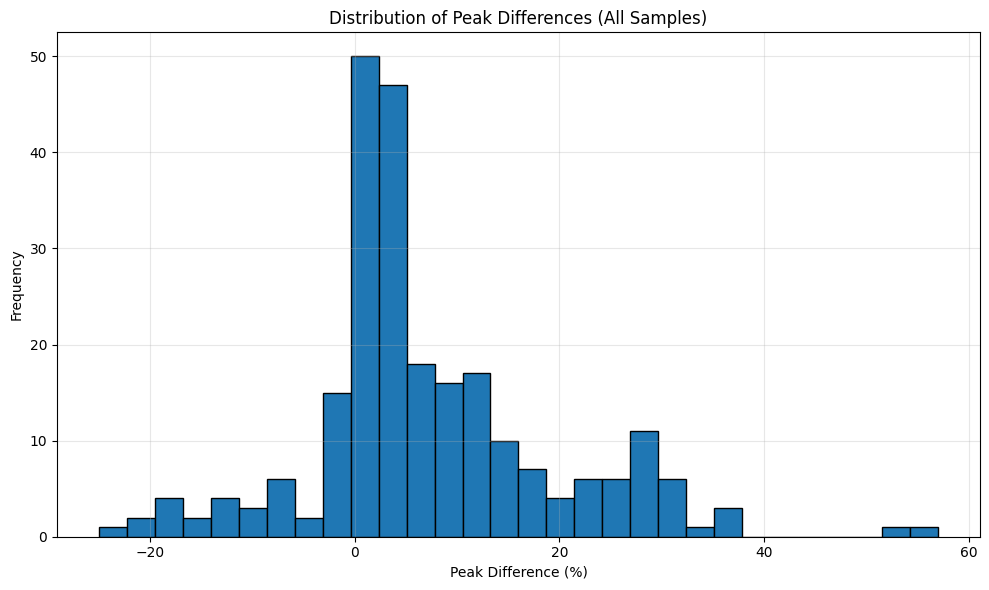

In [19]:
# 全サンプルの定量化結果を統合
all_quant_dfs = []
for res in results:
    df = res['quant_df'].copy()
    df.insert(0, 'sample_name', res['base_name'])
    all_quant_dfs.append(df)

if all_quant_dfs:
    combined_quant = pd.concat(all_quant_dfs, ignore_index=True)
    combined_quant_path = os.path.join(OUTPUT_DIR, "all_samples_quantification.csv")
    combined_quant.to_csv(combined_quant_path, index=False)
    print(f"全サンプルの定量化結果を保存: {combined_quant_path}")
    print(f"  総サンプル数: {len(results)}")
    print(f"  総細胞数: {len(combined_quant)}")
    display(combined_quant.head(10))

# 全サンプルのPeak Difference結果を統合
all_peak_dfs = []
for res in results:
    df = res['peak_df'].copy()
    df.insert(0, 'sample_name', res['base_name'])
    all_peak_dfs.append(df)

if all_peak_dfs:
    combined_peak = pd.concat(all_peak_dfs, ignore_index=True)
    combined_peak_path = os.path.join(OUTPUT_DIR, "all_samples_peak_differences.csv")
    combined_peak.to_csv(combined_peak_path, index=False)
    print(f"\n全サンプルのPeak Difference結果を保存: {combined_peak_path}")
    display(combined_peak.head(10))
    
    # Peak Differenceの統計
    if 'difference_pct' in combined_peak.columns:
        print(f"\n全体のPeak Difference統計:")
        print(f"  平均: {combined_peak['difference_pct'].mean():.2f} %")
        print(f"  中央値: {combined_peak['difference_pct'].median():.2f} %")
        print(f"  標準偏差: {combined_peak['difference_pct'].std():.2f} %")
        
        # ヒストグラム
        plt.figure(figsize=(10, 6))
        plt.hist(combined_peak['difference_pct'].dropna(), bins=30, edgecolor='black')
        plt.xlabel('Peak Difference (%)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Peak Differences (All Samples)')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "peak_difference_histogram.png"), dpi=150)
        plt.show()

# エラーサマリー
if errors:
    print(f"\n\n=== エラー詳細 ===")
    for err in errors:
        print(f"\n{err['base_name']}:")
        print(f"  エラー: {err['error']}")
        if 'traceback' in err:
            print(f"  トレースバック:")
            for line in err['traceback'].split('\n')[:5]:  # 最初の5行のみ表示
                print(f"    {line}")

## 完了！

すべての結果は以下のディレクトリ構成で保存されています:

```
Results/
├── sample1/
│   ├── masks/
│   │   ├── cell_masks.tif                # セグメンテーション結果
│   │   ├── target_mask.tif               # Targetマスク
│   │   ├── reference_mask.tif            # Referenceマスク
│   │   └── radial_mask.tif               # Radial Mask（有効な場合）
│   ├── overlays/
│   │   ├── segmentation_overlay.png      # セグメンテーション可視化
│   │   ├── target_mask_overlay.png       # Targetマスク可視化
│   │   ├── reference_mask_overlay.png    # Referenceマスク可視化
│   │   └── radial_mask_overlay.png       # Radial Mask可視化（有効な場合）
│   ├── radial_profile_plots/
│   │   ├── label1_radial_profile.png     # 各細胞のRadial Profileグラフ
│   │   ├── label2_radial_profile.png
│   │   └── ...
│   ├── quantification.csv                # 定量化結果（全細胞）
│   ├── radial_mask_quantification.csv    # Radial Mask定量化結果（有効な場合）
│   ├── radial_profiles.csv               # Radial Profile結果
│   └── peak_differences.csv              # Peak Difference結果
├── sample2/
│   └── ...
├── all_samples_quantification.csv        # 全サンプル統合 - 定量化
├── all_samples_peak_differences.csv      # 全サンプル統合 - Peak Difference
└── peak_difference_histogram.png         # Peak Difference分布
```

各サンプルごとに独立したディレクトリに保存され、すべての解析結果と可視化が含まれています。

### Radial Mask定量化について
`RADIAL_MASK_PARAMS['enable'] = True`の場合、細胞の外周部分（radial ring）のみでの定量化も実行されます。
- `inner_pct`: 内側の境界（% - 0=中心、100=細胞境界）
- `outer_pct`: 外側の境界（%）

この機能により、細胞の特定の領域（例：細胞膜近傍）での蛍光強度を選択的に定量化できます。